In [1]:
import h5py
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

Using TensorFlow backend.


In [2]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn import metrics
from collections import OrderedDict
import dataexp as dtex # our code
import dataio as dtio # our code 
import preprocessing as pre # our code

from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # SVM
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

# machine learning models/techniques third parties 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.linear_model as sklm

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    for i in range(0,y1.astype('int32').max()+1):
        plt.scatter(X_t[np.where(abs(y1) == i), 0], X_t[np.where(abs(y1) == i), 1], marker='o', color=plt.cm.nipy_spectral(i / 10.), linewidth='1', alpha=0.8, label='{}_label'.format(i))
        
    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();

In [4]:

x_train_o = pd.read_csv('financial_data.csv')
y_train_o = pd.read_csv('revealed_businesses.csv')

x_test_o = pd.read_csv("testing_data.csv")

x_train_o.replace('?', np.nan, inplace=True)
x_train_o = x_train_o.astype('float64')


x_test_o.replace('?', np.nan, inplace=True)
x_test_o = x_test_o.astype('float64')

data_all = x_train_o.merge(y_train_o, on='Var1', how = 'left')

data_nolabel = data_all[data_all.Var66.isnull()]
data_label = data_all[data_all.Var66.notnull()]

data_nolabel_v = data_nolabel.drop(columns=['Var1', 'Var66'])
data_nolabel_id = data_nolabel['Var1']

data_label_v = data_label.drop(columns=['Var1', 'Var66'])
data_label_id = data_label['Var1']

data_nolabel_v_f = data_nolabel_v.fillna(data_nolabel_v.mean())
data_label_v_f = data_label_v.fillna(data_label_v.mean())

In [5]:
X_label = data_label_v_f.values
Y_label = data_label['Var66'].values

In [6]:
#tsne_plot(X_label, Y_label, "original.png")

In [7]:
y_nolabel_ones = np.zeros(data_nolabel_v_f.shape[0])
#tsne_plot(data_nolabel_v_f.values, y_nolabel_ones, "nolabel_original.png")

In [8]:
## input layer 
input_layer = Input(shape=(X_label.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X_label.shape[1], activation='relu')(decoded)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [10]:
x = data_label_v_f.values
y = data_label['Var66'].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x)
x_normal, x_bankrupt = x_scale[y==0], x_scale[y == 1]

In [11]:
autoencoder.fit(x_normal, x_normal, epochs = 20, 
                shuffle = True, validation_split = 0.20, verbose=0);
autoencoder.history.history['loss'][19]

Instructions for updating:
Use tf.cast instead.


0.054329277671139785

In [12]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [13]:
#autoencoder.save('3_24_47.h5')

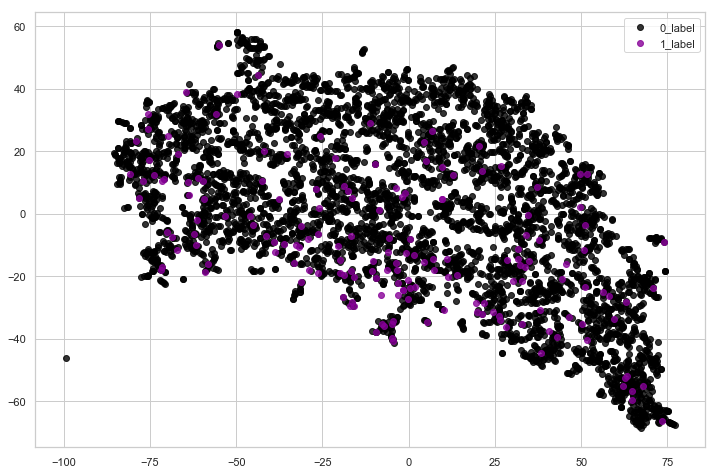

In [14]:
tsne_plot(x_scale, y, "label_original.png")

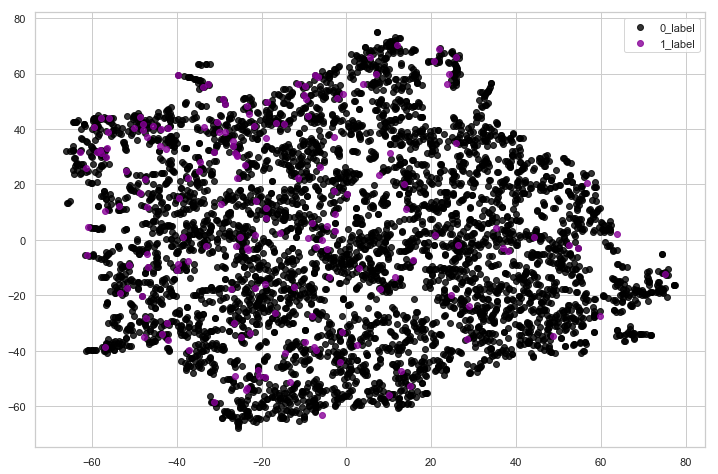

In [15]:
norm_hid_rep = hidden_representation.predict(x_normal)
bankrupt_hid_rep = hidden_representation.predict(x_bankrupt)

rep_x = np.append(norm_hid_rep, bankrupt_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(bankrupt_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_label.png")

In [16]:
x_scale_no = preprocessing.MinMaxScaler().fit_transform(data_nolabel_v_f.values)
test_x = hidden_representation.predict(x_scale_no)

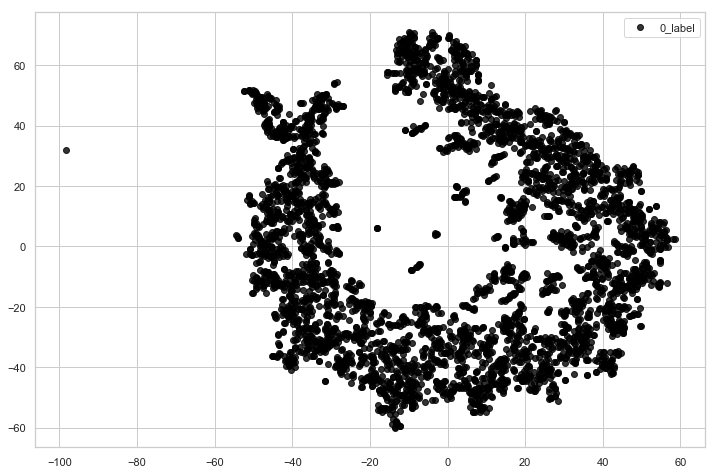

In [17]:
y_nolabel_zeros = np.zeros(data_nolabel_v_f.shape[0])
tsne_plot(x_scale_no, y_nolabel_zeros, "nolabel_original.png")

In [18]:
test_y = np.zeros(data_nolabel_v_f.shape[0])
#tsne_plot(test_x, test_y, "test.png")

In [21]:
cluser = DBSCAN(eps=0.1, min_samples=4).fit(test_x)
labels = cluser.labels_
y_pred = pd.DataFrame(labels, columns=["Var66"])
y_pred.loc[y_pred['Var66'] == -1, 'Var66'] = 1
print(y_pred['Var66'].value_counts())
print(metrics.silhouette_score(test_x, labels))

0    4076
1      48
Name: Var66, dtype: int64
0.93154114


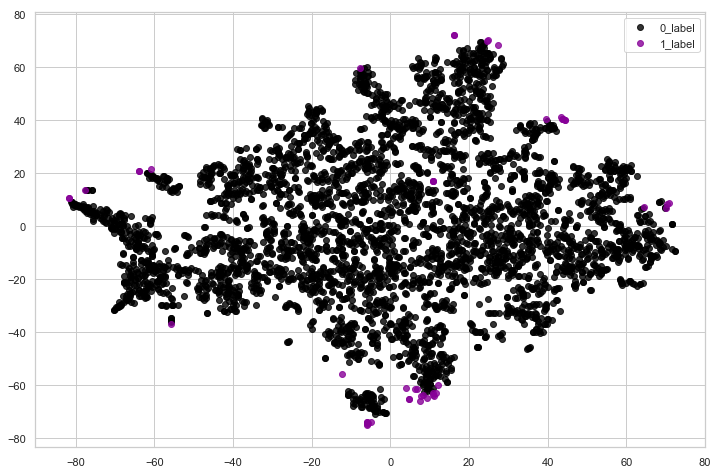

In [22]:
#y_pred.loc[y_pred['Var66'] != 0, 'Var66'] = 1
tsne_plot(test_x, labels, "{}.png".format('DBSCAN'))

In [23]:
df_x_scale = pd.DataFrame(x_scale)
df_label_id = pd.DataFrame(data_label_id.reset_index(drop=True))
df_label_y = pd.DataFrame(data_label['Var66'].reset_index(drop=True))
data_label_all = pd.concat([df_label_id, df_x_scale, df_label_y], axis=1)
data_label_all.columns = data_all.columns

df_x_scale_no = pd.DataFrame(x_scale_no)
df_nolabel_id = pd.DataFrame(data_nolabel_id.reset_index(drop=True))
data_nolabel_pred = pd.concat([df_nolabel_id, df_x_scale_no, y_pred], axis=1)
data_nolabel_pred.columns = data_all.columns

In [24]:
data_tran_all  = pd.concat([data_label_all, data_nolabel_pred], axis=0)

In [25]:
os_dfs_dict = OrderedDict()

os_dfs_dict['mean'] = pre.oversample_smote(data_tran_all, columns = data_tran_all.columns, verbose=True)

original dataset (labels): {0.0: 8785, 1.0: 218}
total: 9003
resampled dataset (labels): {0.0: 8785, 1.0: 8785}
total: 17570



In [26]:
x_test_business_id = x_test_o['Var1']
x_test = x_test_o.drop(columns=['Var1'])
x_test_f = x_test.fillna(x_test.mean())
x_test_f = preprocessing.MinMaxScaler().fit_transform(x_test_f.values)


In [27]:
best_period = os_dfs_dict['mean'][0]
X = best_period.iloc[:,1:-1].values
y = best_period["Var66"].values

# random_forest_classifier_sklearn_roc_all = RandomForestClassifier(criterion="gini", 
#                                                           n_estimators = 10,
#                                                           max_features = "sqrt", 
#                                                           random_state = 94)

# random_forest_classifier_sklearn_roc_all.fit(X, y)
# y_pred_dt = random_forest_classifier_sklearn_roc_all.predict(x_test_f)

bb_classifier_roc_all = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='gini'), 
                                          n_estimators = 15, bootstrap = True, random_state=42)

bb_classifier_roc_all.fit(X, y)
y_pred_dt = bb_classifier_roc_all.predict(x_test_f)


In [28]:
df_y = pd.DataFrame(y_pred_dt, columns=["Is_Bankrupted"])
upload = pd.concat([x_test_business_id, df_y], axis=1)
df_y["Is_Bankrupted"].value_counts()

1    1471
0      29
Name: Is_Bankrupted, dtype: int64

In [29]:
upload = upload.astype('int32')
upload.columns=['Business_ID', 'Is_Bankrupted']
upload.to_csv('3_25_5.csv', index=False)